In [1]:
import torch
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm 
import copy
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("kaggle-download/train.csv")

In [3]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [4]:
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
from datetime import datetime
def parse_time(x):

  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [6]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
    ax = axs[idx // 3, idx % 3]

    # Remove any rows with invalid values
    df_subset = df_trimmed.dropna(subset=v)

    # Create a histogram. Look up the documentation for more details
    ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))

    # Some stylistic things to make the graphs look nice
    ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
    ax.set_facecolor("black")
    ax.set_ylabel("seconds", fontsize=18)
    ax.set_title(f"Feature: {v}", fontsize=20)


NameError: name 'mean' is not defined

In [7]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

NameError: name 'df_trimmed' is not defined

<Figure size 720x720 with 0 Axes>

In [8]:
plt.figure(figsize=(10,10))
hourly_data = df_trimmed["LEN"]
bins=buckets
histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
histogram = histogram / len(hourly_data)
# The center is the left_bound and right_bound of a bucket
bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
plt.plot(bin_centers, histogram, label=f"CALL_TYPE={v}")

NameError: name 'df_trimmed' is not defined

<Figure size 720x720 with 0 Axes>

In [9]:
plt.figure(figsize=(10,10))
for v in ['A','B','C']:
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["CALL_TYPE"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"CALL_TYPE={v}")
plt.legend();

NameError: name 'df_trimmed' is not defined

<Figure size 720x720 with 0 Axes>

In [10]:
df_B = df_tr[df_tr['CALL_TYPE'] == 'B']

In [11]:
df_B_cl = df_B.dropna(subset=['ORIGIN_STAND'])

In [12]:
len(df_B_cl)

806579

In [13]:
stands = sorted(df_B_cl['ORIGIN_STAND'].unique())

In [14]:
len_stands = []
len_err = []
for i in stands:
    m = df_B_cl[df_B_cl['ORIGIN_STAND']==i]['LEN'].mean()
    s = df_B_cl[df_B_cl['ORIGIN_STAND']==i]['LEN'].std()
    len_stands.append(m)
    len_err.append(s)

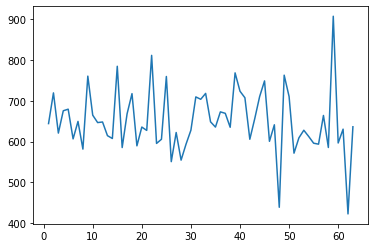

In [15]:
plt.plot(stands,len_stands)

<ErrorbarContainer object of 3 artists>

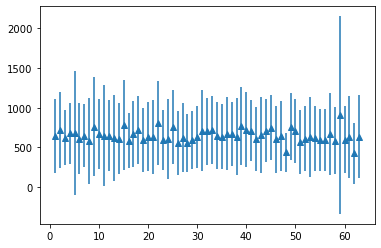

In [16]:
plt.errorbar(stands, len_stands, len_err, linestyle='None', marker='^')

In [17]:
import math

In [18]:
def fillos(x):
    if x['CALL_TYPE'] == 'B':
        if type(x['ORIGIN_STAND']) == None:
            return -1
        else:
            return x['ORIGIN_STAND']
    if x['CALL_TYPE'] == 'A':
        return 0
    else:
        return -1

In [19]:
df_tr['OS_F'] = df_tr.apply(fillos,axis=1)

In [20]:
df_tr['OS_F'].value_counts()

-1.0     528019
 0.0     364770
 15.0     80241
 57.0     50882
 9.0      34818
          ...  
 41.0       506
 43.0       493
 8.0        381
 5.0         53
 48.0         7
Name: OS_F, Length: 65, dtype: int64

In [21]:
ct = pd.get_dummies(df_tr['CALL_TYPE'])
ct.columns = ['ct_A','ct_B','ct_C']

In [22]:
stan = pd.get_dummies(df_tr['OS_F'])

In [23]:
cols = ['YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan.columns)

In [24]:
df_feat = pd.concat([df_tr,ct,stan],axis=1)
X = df_feat[cols].to_numpy().astype(float)
y = df_feat['LEN'].to_numpy().astype(float)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [28]:
device = torch.device('cpu')

In [29]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

In [151]:
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)

In [152]:
model = nn.Sequential(
    nn.Linear(73, 144),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.BatchNorm1d(144),
    nn.Linear(144, 18),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.BatchNorm1d(18),
    nn.Linear(18, 1),
).to(device)

In [153]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [154]:
from torch.optim.lr_scheduler import StepLR 
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [155]:
save = {'w':None,'history':[],'mse':np.inf}

In [214]:
n_epochs = 50   # number of epochs to run
batch_size = 256  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [215]:
best_mse = save['mse']  # init to infinity
best_weights = save['w']
history_train = []
history_test = []

In [230]:
batch_index_history = []

In [231]:
for epoch in tqdm.tqdm(range(1)):
    model.train()
    bar = tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True)
    current_batch = []
    for start in bar:
        # take a batch
        X_batch = X[start:start+batch_size]
        #current_batch += list(range(start,start+batch_size))
        batch_index_history += [np.arange(start, start + batch_size)]
        y_batch = y[start:start+batch_size]
        #y_batch_history += [y_batch]
        # forward pass
        y_pred = model(X_batch)
        a = y_pred.cpu().detach().numpy().transpose()[0]
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
    # evaluate accuracy at end of each epoch
    #scheduler.step()
    batch_index_history += [np.array(current_batch)]
    train_pred = model(X)
    history_train.append(float(loss_fn(train_pred, y)))
    model.eval()
    #y_pred = model(X_test)
    #mse = loss_fn(y_pred, y_test)
    #mse = float(mse)
    #history_test.append(mse)
    #if mse < best_mse:
    #    best_mse = mse
    #    best_weights = copy.deepcopy(model.state_dict())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.59s/it]


In [233]:
batch_mse = {}
y_df = pd.DataFrame(df_feat['LEN'].to_numpy().astype(float))
for i in range(len(batch_index_history)):
    subset_x = df_feat.iloc[batch_index_history[i]]
    subset_y = y_df.iloc[batch_index_history[i]]
    X_batch = subset[cols].to_numpy().astype(float)
    X_batch = torch.tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.tensor(subset_y[0].to_numpy().astype(float), dtype=torch.float32).reshape(-1, 1).to(device)
    preds = model(X_batch)
    try:
        batch_mse[i] = int(loss_fn(preds, y_batch))
    except RuntimeError as e:
        print(batch_index_history[i])#len(preds), len(y_batch))

[]


C:\Users\Jimmy\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([0, 1])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [242]:
highest_MSE_samples = list(pd.Series(batch_mse).nlargest(10).index)

In [268]:
a = df_feat.iloc[batch_index_history[0]]

In [271]:
a

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,...,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,...,0,0,0,0,0,0,0,0,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,...,0,0,0,0,0,0,0,0,0,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,...,0,0,0,0,0,0,0,0,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,...,0,0,0,0,0,0,0,0,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,1372648996620000657,A,58137.0,NaN,20000657,1372648996,A,False,"[[-8.68239,41.160672],[-8.683092,41.160456],[-...",450,...,0,0,0,0,0,0,0,0,0,0
252,1372651688620000173,B,NaN,6.0,20000173,1372651688,A,False,"[[-8.582553,41.180535],[-8.582211,41.180238],[...",150,...,0,0,0,0,0,0,0,0,0,0
253,1372651027620000600,B,NaN,23.0,20000600,1372651027,A,False,"[[-8.612613,41.145957],[-8.612451,41.145993],[...",210,...,0,0,0,0,0,0,0,0,0,0
254,1372651200620000011,B,NaN,12.0,20000011,1372651200,A,False,"[[-8.630433,41.154831],[-8.631,41.154381],[-8....",555,...,0,0,0,0,0,0,0,0,0,0


In [278]:
long

,longitude
0,"(-8.62, -8.598]"
1,"(-8.62, -8.598]"
2,"(-8.62, -8.598]"
3,"(-8.643, -8.62]"
4,"(-8.643, -8.62]"
...,...
10775,"(-8.643, -8.62]"
10776,"(-8.643, -8.62]"
10777,"(-8.643, -8.62]"
10778,"(-8.643, -8.62]"


In [298]:
import re
import seaborn as sns

def make_heatmap(df):
    long = df['POLYLINE'].apply(lambda x: re.findall(r'\[(-\d+\.\d+),', x))
    long_coords = []
    for i in long:
        long_coords += i
    long_coords = pd.cut(list(map(float,long_coords)), 10, retbins=True)
    long = pd.DataFrame({'longitude':long_coords[0]})
    lat = df['POLYLINE'].apply(lambda x: re.findall('\,(\d+\.\d+)', x))
    lat_coords = []
    for i in lat:
        lat_coords += i
    lat_coords = pd.cut(list(map(float,lat_coords)), 10, retbins=True)
    lat = pd.DataFrame({'latitude':lat_coords[0]})
    binned_data = long.join(lat)
    binned_data[2] = np.ones(len(binned_data))
    mapped_data = binned_data.groupby(["longitude", "latitude"])[2].count().unstack()
    log_mapped_data = mapped_data.apply(lambda x: np.log(x+1))
    sns.heatmap(log_mapped_data, linewidths = 0.30, annot = True, cmap=sns.cubehelix_palette(as_cmap=True))
    plt.show()

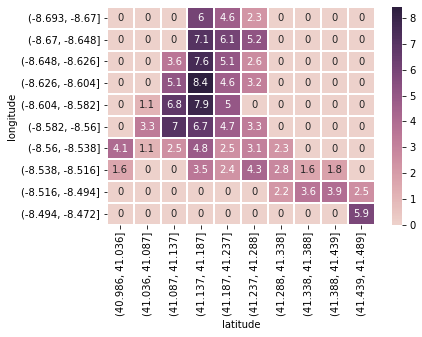

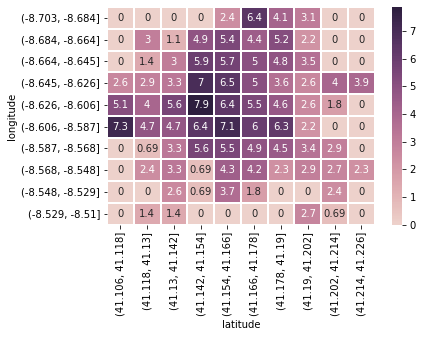

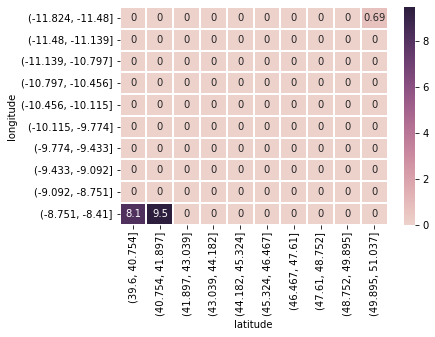

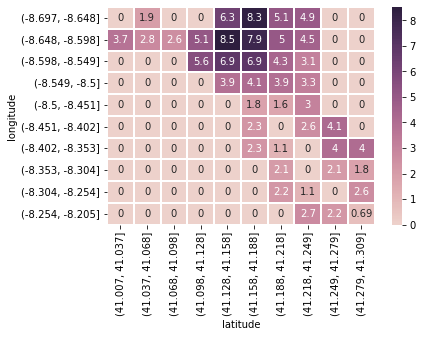

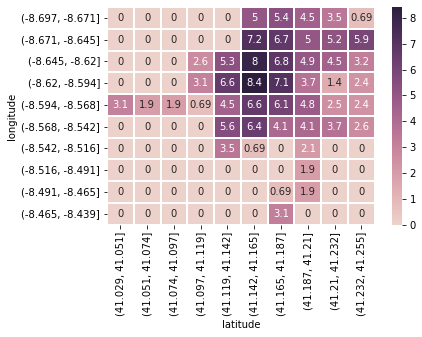

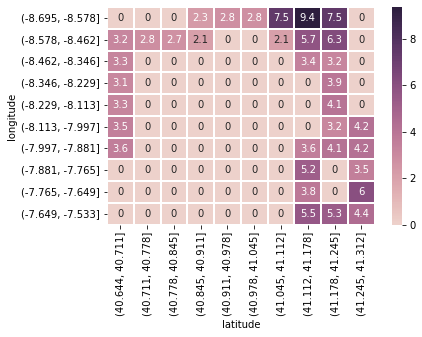

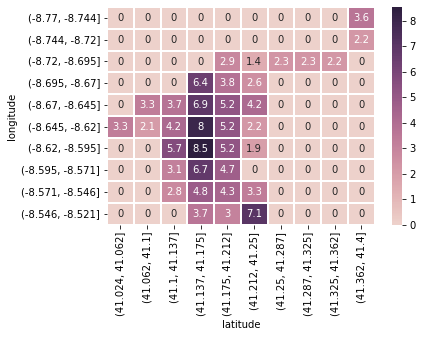

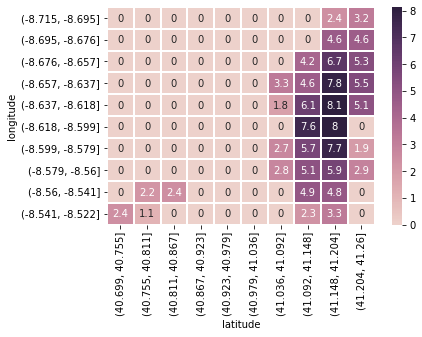

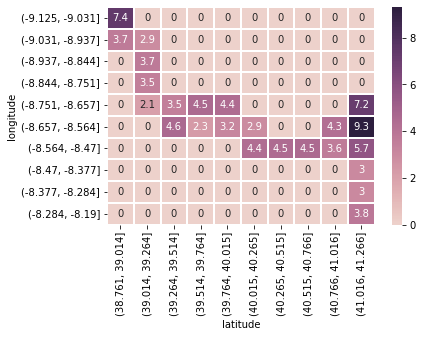

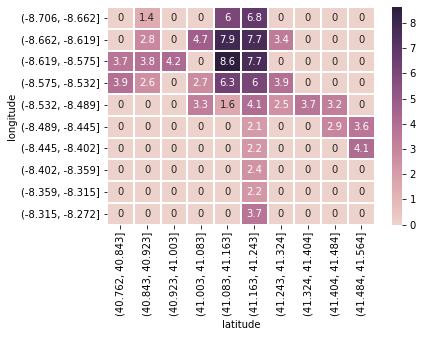

In [300]:
for i in highest_MSE_samples:
    make_heatmap(df_feat.iloc[batch_index_history[i]])

In [296]:
maps[0]

In [167]:
df_feat.iloc[batch_index_history[0]]['POLYLINE']

0      [[-8.618643,41.141412],[-8.618499,41.141376],[...
1      [[-8.639847,41.159826],[-8.640351,41.159871],[...
2      [[-8.612964,41.140359],[-8.613378,41.14035],[-...
3      [[-8.574678,41.151951],[-8.574705,41.151942],[...
4      [[-8.645994,41.18049],[-8.645949,41.180517],[-...
                             ...                        
251    [[-8.68239,41.160672],[-8.683092,41.160456],[-...
252    [[-8.582553,41.180535],[-8.582211,41.180238],[...
253    [[-8.612613,41.145957],[-8.612451,41.145993],[...
254    [[-8.630433,41.154831],[-8.631,41.154381],[-8....
255    [[-8.609634,41.151294],[-8.609535,41.151456],[...
Name: POLYLINE, Length: 256, dtype: object

In [161]:
batch_mse = []
for batch in batch_index_history:
    for df

SyntaxError: invalid syntax (537841298.py, line 3)

In [ ]:
polylines = []

In [89]:
for b in batch_index_history:
    for i in b:
        print(i)

0
1
2
256
257
258
512
513
514
768
769
770
1024
1025
1026
1280
1281
1282
1536
1537
1538
1792
1793
1794
2048
2049
2050
2304
2305
2306
2560
2561
2562
2816
2817
2818
3072
3073
3074
3328
3329
3330
3584
3585
3586
3840
3841
3842
4096
4097
4098
4352
4353
4354
4608
4609
4610
4864
4865
4866
5120
5121
5122
5376
5377
5378
5632
5633
5634
5888
5889
5890
6144
6145
6146
6400
6401
6402
6656
6657
6658
6912
6913
6914
7168
7169
7170
7424
7425
7426
7680
7681
7682
7936
7937
7938
8192
8193
8194
8448
8449
8450
8704
8705
8706
8960
8961
8962
9216
9217
9218
9472
9473
9474
9728
9729
9730
9984
9985
9986
10240
10241
10242
10496
10497
10498
10752
10753
10754
11008
11009
11010
11264
11265
11266
11520
11521
11522
11776
11777
11778
12032
12033
12034
12288
12289
12290
12544
12545
12546
12800
12801
12802
13056
13057
13058
13312
13313
13314
13568
13569
13570
13824
13825
13826
14080
14081
14082
14336
14337
14338
14592
14593
14594
14848
14849
14850
15104
15105
15106
15360
15361
15362
15616
15617
15618
15872
15873
15874
1612

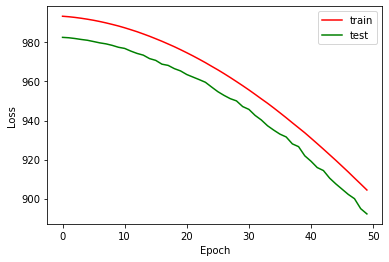

In [63]:
# Plotting both the curves simultaneously
plt.plot(np.sqrt(history_train), color='r', label='train')
plt.plot(np.sqrt(history_test), color='g', label='test')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [66]:
X_batch_history[0][0]

tensor([2.0140e+03, 5.0000e+00, 1.2000e+01, 1.5000e+01, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00])

In [ ]:
plt.plot(history_train, color='r', label='train')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [ ]:
test = pd.read_csv('kaggle-download/test_public.csv')
tid =  test[['TRIP_ID']]
test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
ct_test = pd.get_dummies(test['CALL_TYPE'])
ct_test.columns = ['ct_A','ct_B','ct_C']
enc = OneHotEncoder()
enc.fit(np.array(df_tr[['OS_F']]))
test['OS_F'] = test.apply(fillos,axis=1)
stan_test = pd.DataFrame(enc.transform(test[['OS_F']]).toarray())
stan_test.columns = stan_test.columns -1
stan_test = stan_test.drop([64],axis=1)
test = pd.concat([test,ct_test,stan_test],axis=1)
test = test[['YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan_test.columns)].to_numpy().astype(float)
test = torch.tensor(test, dtype=torch.float32).to(device)

In [ ]:
test

In [ ]:
model.load_state_dict(best_weights)

In [ ]:
model.load_state_dict(torch.load('weight.pt'))

In [ ]:
pred = model(test).cpu().detach().numpy().transpose()[0]
tid['TRAVEL_TIME'] = pred
tid

In [ ]:
model.

In [ ]:
tid.to_csv('sampSubmission3.csv',index=False)

In [ ]:
torch.save(best_weights, 'weight.pt')

In [ ]:
Xt = torch.tensor(X,dtype=torch.float32).to(device)
yt = torch.tensor(X,dtype=torch.float32).to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dist = pd.DataFrame((model(Xt) - yt).cpu().detach().numpy().transpose()[0])

In [ ]:
dist

In [ ]:
plt.hist(dist, y=0, density=True);

In [ ]:
pred = model(Xt)

In [ ]:
pred = pred.cpu().detach().numpy()

In [ ]:
pred - y